In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
root_path = './dataset/'

In [3]:
comportamiento_df = pd.read_csv(f'{root_path}comportamiento_tarjetasvisa.csv', sep = ',')

In [4]:
informacion_df = pd.read_csv(f'{root_path}informacion_adicional_tarjetas.csv', sep = ',')

In [5]:
comportamiento_df['ID_CLIENTE'].value_counts().shape[0]

45985

In [6]:
informacion_df['ID_CLIENTE'].value_counts().shape[0]

438510

### Definición de mal pagador

In [8]:
comportamiento_df.drop_duplicates()
comportamiento_df

,ID_CLIENTE,MESES,DIAS_VENCIDOS
0,5001711,0,NaN
1,5001711,-1,11.0
2,5001711,-2,16.0
3,5001711,-3,16.0
4,5001712,0,0.0
...,...,...,...
1048570,5150487,-25,0.0
1048571,5150487,-26,0.0
1048572,5150487,-27,0.0
1048573,5150487,-28,0.0


In [9]:
comportamiento_df.isnull().sum()

ID_CLIENTE            0
MESES                 0
DIAS_VENCIDOS    209230
dtype: int64

##### 20% de las observaciones son nulas en columna DIAS_VENCIDOS

In [11]:
grupo_df = comportamiento_df.groupby(["ID_CLIENTE","MESES"]).max()
grupo_df

DIAS_VENCIDOS
ID_CLIENTE MESES               
5001711    -3              16.0
           -2              16.0
           -1              11.0
            0               NaN
5001712    -18             17.0
...                         ...
5150487    -4               0.0
           -3               0.0
           -2               0.0
           -1               0.0
            0               0.0

[1048575 rows x 1 columns]

In [12]:
filtro_nulos = comportamiento_df.groupby('ID_CLIENTE').filter(lambda x:x['DIAS_VENCIDOS'].isnull().any())
filtro_nulos['ID_CLIENTE'].value_counts()

ID_CLIENTE
5059942    61
5005201    61
5002806    61
5105565    61
5017058    61
           ..
5047681     1
5021959     1
5125464     1
5092092     1
5137027     1
Name: count, Length: 25005, dtype: int64

##### De un total de 45,985 clientes con comportamiento del manejo de tarjeta, 25,005 clientes tienen al menos un campo nulo en dias vencidos.

##### Se consideran todas las observaciones para definir el tipo de pagador toda vez que podemos asegurar un mal comportamiento con información cierta.

##### Score de comportamiento:
Mayor que 25 y menor igual que 30, se puntúa el comportamiento con 0.25.
Mayor que 30, se puntúa con 1.

In [16]:
# funcion para score comportamiento
def score_comportamiento(dias_vencidos):
    if dias_vencidos > 25 and dias_vencidos <= 30:
        return 0.25
    elif dias_vencidos > 30:
        return 1
    else:
        return 0

In [17]:
comportamiento_df['SCORE'] = comportamiento_df['DIAS_VENCIDOS'].apply(score_comportamiento)
comportamiento_df['MESES_ANTIGUEDAD'] = (comportamiento_df.groupby('ID_CLIENTE')['MESES'].transform('min')) * (-1)
comportamiento_df

,ID_CLIENTE,MESES,DIAS_VENCIDOS,SCORE,MESES_ANTIGUEDAD
0,5001711,0,NaN,0.0,3
1,5001711,-1,11.0,0.0,3
2,5001711,-2,16.0,0.0,3
3,5001711,-3,16.0,0.0,3
4,5001712,0,0.0,0.0,18
...,...,...,...,...,...
1048570,5150487,-25,0.0,0.0,29
1048571,5150487,-26,0.0,0.0,29
1048572,5150487,-27,0.0,0.0,29
1048573,5150487,-28,0.0,0.0,29


In [18]:
calificacion_df = comportamiento_df[["ID_CLIENTE","MESES_ANTIGUEDAD","SCORE"]].groupby(["ID_CLIENTE","MESES_ANTIGUEDAD"]).sum().reset_index()
calificacion_df

,ID_CLIENTE,MESES_ANTIGUEDAD,SCORE
0,5001711,3,0.00
1,5001712,18,0.25
2,5001713,21,0.00
3,5001714,14,0.00
4,5001715,59,0.00
...,...,...,...
45980,5150482,28,0.25
45981,5150483,17,0.00
45982,5150484,12,0.50
45983,5150485,1,0.25


In [19]:
# definir etiqueta de mal pagador
def tipo_cliente(meses_antiguedad, score_total):
    if meses_antiguedad <= 6 and score_total > 0:
        return 'mal pagador'
    elif meses_antiguedad > 6 and meses_antiguedad <= 12 and score_total > 0.5:
        return 'mal pagador'
    elif meses_antiguedad > 12 and meses_antiguedad <= 24 and score_total >= 1.5:
        return 'mal pagador'
    elif meses_antiguedad > 24 and meses_antiguedad <= 36 and score_total >= 2.5:
        return 'mal pagador'
    elif meses_antiguedad > 36 and meses_antiguedad <= 48 and score_total >= 3.5:
        return 'mal pagador'
    elif meses_antiguedad > 48 and meses_antiguedad <= 60 and score_total >= 4.5:
        return 'mal pagador'
    elif meses_antiguedad > 60 and score_total >= 5.5:
        return 'mal pagador'
    else:
        return 'buen pagador'

In [20]:
calificacion_df['TIPO_CLIENTE'] = calificacion_df.apply(lambda x: tipo_cliente(x['MESES_ANTIGUEDAD'], x['SCORE']), axis=1)
calificacion_df['TIPO_CLIENTE'].value_counts(normalize=True)

TIPO_CLIENTE
buen pagador    0.907426
mal pagador     0.092574
Name: proportion, dtype: float64

### Join con información adicional del cliente

In [22]:
calificacion_df.isnull().sum()

ID_CLIENTE          0
MESES_ANTIGUEDAD    0
SCORE               0
TIPO_CLIENTE        0
dtype: int64

In [23]:
calificacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_CLIENTE        45985 non-null  int64  
 1   MESES_ANTIGUEDAD  45985 non-null  int64  
 2   SCORE             45985 non-null  float64
 3   TIPO_CLIENTE      45985 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB


No se tiene valores nulos con el nuevo dataset con la definición de mal pagador

In [25]:
#Se crea un nuevo data con las dos columnas solicitadas CLIENTE_ID (ID_CLIENTE) y mal_pagador (TIPO_CLIENTE)
definicion_df = calificacion_df[["ID_CLIENTE", "TIPO_CLIENTE"]]
definicion_df

,ID_CLIENTE,TIPO_CLIENTE
0,5001711,buen pagador
1,5001712,buen pagador
2,5001713,buen pagador
3,5001714,buen pagador
4,5001715,buen pagador
...,...,...
45980,5150482,buen pagador
45981,5150483,buen pagador
45982,5150484,buen pagador
45983,5150485,mal pagador


In [26]:
#Análisis del dataset con la información de los clientes
informacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID_CLIENTE                  438557 non-null  int64  
 1   GENERO                      438557 non-null  object 
 2   TIENE_CARRO                 438557 non-null  int64  
 3   TIENE_PROPIEDADES           438557 non-null  int64  
 4   N_NINOS                     438557 non-null  int64  
 5   INGRESO_ANUAL               438557 non-null  float64
 6   CATEGORIA_INGRESO           438557 non-null  object 
 7   NIVEL_EDUCACION             438557 non-null  object 
 8   ESTADO_CIVIL                438557 non-null  object 
 9   TIPO_CASA                   438557 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       438557 non-null  int64  
 11  DIAS_TRABAJANDO             438557 non-null  int64  
 12  TIENE_CELULAR               438557 non-null  int64  
 13  TIENE_NUMEROTE

In [27]:
informacion_df.drop_duplicates()
informacion_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [28]:
informacion_df.isnull().sum()

ID_CLIENTE                         0
GENERO                             0
TIENE_CARRO                        0
TIENE_PROPIEDADES                  0
N_NINOS                            0
INGRESO_ANUAL                      0
CATEGORIA_INGRESO                  0
NIVEL_EDUCACION                    0
ESTADO_CIVIL                       0
TIPO_CASA                          0
DIAS_DESDE_NACIMIENTO              0
DIAS_TRABAJANDO                    0
TIENE_CELULAR                      0
TIENE_NUMEROTELEF_LABORAL          0
TIENE_NUMEROTELEF_PERSONAL         0
TIENE_EMAIL                        0
PROFESION                     134203
N_MIEMBROSFAMILIA                  0
dtype: int64

In [29]:
id_informacion_df = informacion_df["ID_CLIENTE"].value_counts()
id_informacion_df

ID_CLIENTE
7137299    2
7702238    2
7282535    2
7243768    2
7050948    2
          ..
5690727    1
6621262    1
6621261    1
6621260    1
6842885    1
Name: count, Length: 438510, dtype: int64

In [30]:
#Observando los valores repetidos
repetido_informacion_df = id_informacion_df[id_informacion_df > 1].index
repetido_informacion_df

Index([7137299, 7702238, 7282535, 7243768, 7050948, 7602432, 7036518, 7045885,
       7618285, 7089090, 7052783, 7416167, 7023108, 7045794, 7053557, 7207977,
       7836711, 7772847, 7154819, 7052812, 7099881, 7022327, 7833087, 7743418,
       7836971, 7372589, 7636756, 7636389, 7213374, 7317997, 7838075, 7023651,
       7155150, 7091721, 7046068, 7742298, 7744386, 7702516, 7022197, 7154598,
       7742853, 7090931, 7135270, 7024111, 7174719, 7603224, 7576316],
      dtype='int64', name='ID_CLIENTE')

In [31]:
repetido_filtro_df = informacion_df[informacion_df['ID_CLIENTE'].isin(repetido_informacion_df)].sort_values(by="ID_CLIENTE")
repetido_filtro_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
426818,7022197,M,1,1,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,0,1,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,0,1,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,1,1,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,1,1,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,0,1,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,1,0,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,0,1,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,0,1,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


Se descartan los ids que tienen más de una información porque los valores cambiantes no siguen ningún patrón (MCAR)

94 registros se han descartado de la información de clientes

In [34]:
#Obteniedo los id con información única
filtered_informacion_df = id_informacion_df[id_informacion_df == 1].index
filtered_informacion_df

Index([6147693, 6147702, 6147689, 6147705, 6147690, 6147691, 6147704, 6147703,
       6147634, 6147638,
       ...
       6621267, 6621266, 6621265, 6621264, 6621263, 5690727, 6621262, 6621261,
       6621260, 6842885],
      dtype='int64', name='ID_CLIENTE', length=438463)

In [35]:
#Filtrando los ids únicos
unicos_informacion_df = informacion_df[informacion_df['ID_CLIENTE'].isin(filtered_informacion_df)]
unicos_informacion_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [36]:
unificado_df = unicos_informacion_df.merge(definicion_df, how="left", on="ID_CLIENTE")
unificado_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,buen pagador
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,buen pagador
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,buen pagador
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,buen pagador
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,buen pagador
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438458,6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0,NaN
438459,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,NaN
438460,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,NaN
438461,6842765,F,0,1,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0,NaN


### Data quality

In [38]:
#Analizando la información unificada
unificado_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438463 entries, 0 to 438462
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID_CLIENTE                  438463 non-null  int64  
 1   GENERO                      438463 non-null  object 
 2   TIENE_CARRO                 438463 non-null  int64  
 3   TIENE_PROPIEDADES           438463 non-null  int64  
 4   N_NINOS                     438463 non-null  int64  
 5   INGRESO_ANUAL               438463 non-null  float64
 6   CATEGORIA_INGRESO           438463 non-null  object 
 7   NIVEL_EDUCACION             438463 non-null  object 
 8   ESTADO_CIVIL                438463 non-null  object 
 9   TIPO_CASA                   438463 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       438463 non-null  int64  
 11  DIAS_TRABAJANDO             438463 non-null  int64  
 12  TIENE_CELULAR               438463 non-null  int64  
 13  TIENE_NUMEROTE

Hay 402006 registros lo que representa el 91 % de información nula porque los ids de clientes no estaban en la definición del tipo de cliente.
Es un categoría necesaria para analizar el tipo de cliente se va a trabajar con clientes que si estén categorizados

In [40]:
unificado_df[unificado_df.duplicated() == True]

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE


No se tiene valores duplicados ya que desde el inicio se usó la función drop_duplicates para no trabajar con valores repetidos

In [42]:
#Se conservan los registros que no tienen valores nulos para el tipo de cliente según la definición de mal pagador
clientes_df = unificado_df[unificado_df["TIPO_CLIENTE"].isnull() == False]
clientes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 0 to 434718
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID_CLIENTE                  36457 non-null  int64  
 1   GENERO                      36457 non-null  object 
 2   TIENE_CARRO                 36457 non-null  int64  
 3   TIENE_PROPIEDADES           36457 non-null  int64  
 4   N_NINOS                     36457 non-null  int64  
 5   INGRESO_ANUAL               36457 non-null  float64
 6   CATEGORIA_INGRESO           36457 non-null  object 
 7   NIVEL_EDUCACION             36457 non-null  object 
 8   ESTADO_CIVIL                36457 non-null  object 
 9   TIPO_CASA                   36457 non-null  object 
 10  DIAS_DESDE_NACIMIENTO       36457 non-null  int64  
 11  DIAS_TRABAJANDO             36457 non-null  int64  
 12  TIENE_CELULAR               36457 non-null  int64  
 13  TIENE_NUMEROTELEF_LABORAL   36457 n

In [43]:
clientes_df[["TIPO_CLIENTE", "ID_CLIENTE"]].groupby("TIPO_CLIENTE").count()

,ID_CLIENTE
TIPO_CLIENTE,
buen pagador,32959
mal pagador,3498


##### El 31% de las observaciones para la información de las tarjetas es nula en la descripción de la profesión

In [45]:
segun_genero_df = clientes_df[["GENERO", "PROFESION", "ID_CLIENTE"]].groupby("GENERO").count()
segun_genero_df

,PROFESION,ID_CLIENTE
GENERO,,
F,15630,24430
M,9504,12027


In [46]:
segun_genero_df["SIN PROFESION"] = segun_genero_df["ID_CLIENTE"] - segun_genero_df["PROFESION"]
segun_genero_df["% SIN PROFESION"] = (segun_genero_df["SIN PROFESION"] * 100)/segun_genero_df["ID_CLIENTE"]
segun_genero_df

,PROFESION,ID_CLIENTE,SIN PROFESION,% SIN PROFESION
GENERO,,,,
F,15630,24430,8800,36.021285
M,9504,12027,2523,20.977800


El 36 % de mujeres no ha indicado que profesión tienen y el 21% de los hombres prefirieron no decir a que se dedican

### Feature transformation

In [49]:
clientes_df.describe()

,ID_CLIENTE,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,N_MIEMBROSFAMILIA
count,3.645700e+04,36457.000000,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.379708,0.672189,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453
std,4.187524e+04,0.485321,0.469422,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686
min,5.008804e+06,0.000000,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.042028e+06,0.000000,0.000000,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,5.074614e+06,0.000000,1.000000,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,5.115396e+06,1.000000,1.000000,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,5.150487e+06,1.000000,1.000000,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [50]:
fecha_fijada = datetime(2024, 6, 29).date()
clientes_df['FECHA_NACIMIENTO'] = clientes_df['DIAS_DESDE_NACIMIENTO'].apply(lambda x: fecha_fijada + timedelta(days=x))
clientes_df['ANIO_NACIMIENTO'] = clientes_df['FECHA_NACIMIENTO'].apply(lambda x: x.year)
clientes_df

C:\Users\mrumb\AppData\Local\Temp\ipykernel_8344\3620495674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df['FECHA_NACIMIENTO'] = clientes_df['DIAS_DESDE_NACIMIENTO'].apply(lambda x: fecha_fijada + timedelta(days=x))
C:\Users\mrumb\AppData\Local\Temp\ipykernel_8344\3620495674.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df['ANIO_NACIMIENTO'] = clientes_df['FECHA_NACIMIENTO'].apply(lambda x: x.year)


,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,...,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE,FECHA_NACIMIENTO,ANIO_NACIMIENTO
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,buen pagador,1991-08-17,1991
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,buen pagador,1991-08-17,1991
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,buen pagador,1965-09-13,1965
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,buen pagador,1972-03-04,1972
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,buen pagador,1972-03-04,1972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434714,5149828,M,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,-2420,1,0,0,0,Managers,2.0,mal pagador,1976-12-30,1976
434715,5149834,F,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,mal pagador,1990-07-31,1990
434716,5149838,F,0,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,mal pagador,1990-07-31,1990
434717,5150049,F,0,1,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,-655,1,0,0,0,Sales staff,2.0,mal pagador,1975-04-30,1975


In [51]:
#funcion para etiqueta generacional
def generacion(anio_nacimiento):
    if anio_nacimiento >= 1997:
        return 'Generación Z'
    elif 1981 <= anio_nacimiento < 1997:
        return 'Millennials'
    elif 1965 <= anio_nacimiento < 1981:
        return 'Generación X'
    elif 1946 <= anio_nacimiento < 1965:
        return 'Baby Boomers'
    else:
        return 'Generación Silenciosa'
clientes_df['GENERACION'] = clientes_df['ANIO_NACIMIENTO'].apply(generacion)

C:\Users\mrumb\AppData\Local\Temp\ipykernel_8344\2287765963.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df['GENERACION'] = clientes_df['ANIO_NACIMIENTO'].apply(generacion)


In [52]:
clientes_df['GENERACION'].value_counts()

GENERACION
Millennials     16690
Generación X    13209
Baby Boomers     4233
Generación Z     2325
Name: count, dtype: int64

In [53]:
generacion_df = pd.crosstab(clientes_df['GENERACION'], clientes_df["TIPO_CLIENTE"], normalize="index")

In [54]:
generacion_df.reindex(["Generación Z", "Millennials", "Generación X", "Baby Boomers"])

TIPO_CLIENTE,buen pagador,mal pagador
GENERACION,,
Generación Z,0.872688,0.127312
Millennials,0.902516,0.097484
Generación X,0.909380,0.090620
Baby Boomers,0.910702,0.089298


In [55]:
def rangos_ingresos(ingresos_anuales):
    if ingresos_anuales <= (27000 + 516000):
        ## rango hasta 543000
        return "Ingresos bajos"
    elif ingresos_anuales >= (1575000 - 516000):  
        ## ranngo desde 1059000 
        return "Ingresos altos"
    else:
        return "Ingresos medios"
    
clientes_df["NIVEL_INGRESOS"] = clientes_df["INGRESO_ANUAL"].apply(rangos_ingresos)


C:\Users\mrumb\AppData\Local\Temp\ipykernel_8344\37054215.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df["NIVEL_INGRESOS"] = clientes_df["INGRESO_ANUAL"].apply(rangos_ingresos)


In [56]:
def conversion_tipo_cliente (tipo_cliente):
    if tipo_cliente == "buen pagador": 
        return 1
    else:
        return 0
clientes_df['NUM_TIPO_CLIENTE'] = clientes_df.apply(lambda x: conversion_tipo_cliente(x["TIPO_CLIENTE"]), axis=1)

C:\Users\mrumb\AppData\Local\Temp\ipykernel_8344\3166890137.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_df['NUM_TIPO_CLIENTE'] = clientes_df.apply(lambda x: conversion_tipo_cliente(x["TIPO_CLIENTE"]), axis=1)


In [57]:
clientes_df.isnull().sum()/clientes_df.shape[0]

ID_CLIENTE                    0.000000
GENERO                        0.000000
TIENE_CARRO                   0.000000
TIENE_PROPIEDADES             0.000000
N_NINOS                       0.000000
INGRESO_ANUAL                 0.000000
CATEGORIA_INGRESO             0.000000
NIVEL_EDUCACION               0.000000
ESTADO_CIVIL                  0.000000
TIPO_CASA                     0.000000
DIAS_DESDE_NACIMIENTO         0.000000
DIAS_TRABAJANDO               0.000000
TIENE_CELULAR                 0.000000
TIENE_NUMEROTELEF_LABORAL     0.000000
TIENE_NUMEROTELEF_PERSONAL    0.000000
TIENE_EMAIL                   0.000000
PROFESION                     0.310585
N_MIEMBROSFAMILIA             0.000000
TIPO_CLIENTE                  0.000000
FECHA_NACIMIENTO              0.000000
ANIO_NACIMIENTO               0.000000
GENERACION                    0.000000
NIVEL_INGRESOS                0.000000
NUM_TIPO_CLIENTE              0.000000
dtype: float64

In [58]:
def reemplazar_nulos(c):
    if c.dtype == "object":
        return c.apply(lambda x: "Desconocido" if pd.isnull(x) else x)
    else:
        mediana = c.median()
        return c.apply(lambda x: mediana if pd.isnull(x) else x)

In [59]:
clientes_df = clientes_df.apply(reemplazar_nulos)

In [60]:
clientes_df.isnull().sum()/clientes_df.shape[0]

ID_CLIENTE                    0.0
GENERO                        0.0
TIENE_CARRO                   0.0
TIENE_PROPIEDADES             0.0
N_NINOS                       0.0
INGRESO_ANUAL                 0.0
CATEGORIA_INGRESO             0.0
NIVEL_EDUCACION               0.0
ESTADO_CIVIL                  0.0
TIPO_CASA                     0.0
DIAS_DESDE_NACIMIENTO         0.0
DIAS_TRABAJANDO               0.0
TIENE_CELULAR                 0.0
TIENE_NUMEROTELEF_LABORAL     0.0
TIENE_NUMEROTELEF_PERSONAL    0.0
TIENE_EMAIL                   0.0
PROFESION                     0.0
N_MIEMBROSFAMILIA             0.0
TIPO_CLIENTE                  0.0
FECHA_NACIMIENTO              0.0
ANIO_NACIMIENTO               0.0
GENERACION                    0.0
NIVEL_INGRESOS                0.0
NUM_TIPO_CLIENTE              0.0
dtype: float64

In [61]:
def categoria_hijos(nino):
    if nino == 0:
        return "Sin hijos"
    elif nino >= 1 or nino < 3:
        return "De 1 a 2 hijos"
    else:
        return "Familia numerosa"
    
clientes_df["CAT_HIJOS"] = clientes_df["N_NINOS"].apply(categoria_hijos)

### Análisis descriptivo

In [63]:
#Descripción general de todas las variables
clientes_df.describe()

,ID_CLIENTE,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,N_MIEMBROSFAMILIA,ANIO_NACIMIENTO,NUM_TIPO_CLIENTE
count,3.645700e+04,36457.000000,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.379708,0.672189,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,1980.247908,0.904051
std,4.187524e+04,0.485321,0.469422,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,11.511638,0.294525
min,5.008804e+06,0.000000,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,1955.000000,0.000000
25%,5.042028e+06,0.000000,0.000000,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,1971.000000,1.000000
50%,5.074614e+06,0.000000,1.000000,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,1981.000000,1.000000
75%,5.115396e+06,1.000000,1.000000,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,1990.000000,1.000000
max,5.150487e+06,1.000000,1.000000,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,2003.000000,1.000000


¿Cuál es la profesión de más o menos riesgo? ¿Los ingresos según la profesión tienen un impacto en el tipo de cliente?

In [65]:
clientes_df["PROFESION"].describe()

count           36457
unique             19
top       Desconocido
freq            11323
Name: PROFESION, dtype: object

In [66]:
proporcion_profesion = clientes_df['PROFESION'].value_counts(normalize=True)
proporcion_profesion

PROFESION
Desconocido              0.310585
Laborers                 0.170365
Core staff               0.098500
Sales staff              0.095592
Managers                 0.082618
Drivers                  0.058644
High skill tech staff    0.037935
Accountants              0.034040
Medicine staff           0.033107
Cooking staff            0.017966
Security staff           0.016238
Cleaning staff           0.015114
Private service staff    0.009436
Low-skill Laborers       0.004800
Waiters/barmen staff     0.004773
Secretaries              0.004142
HR staff                 0.002332
Realty agents            0.002167
IT staff                 0.001646
Name: proportion, dtype: float64

In [111]:
tabla_contingencia = pd.crosstab(clientes_df['PROFESION'], clientes_df['TIPO_CLIENTE'], normalize=True, margins=True)
tabla_ordenada_filas = tabla_contingencia.sort_values(by='buen pagador', ascending=False)
tabla_ordenada_filas

TIPO_CLIENTE,buen pagador,mal pagador,All
PROFESION,,,
All,0.904051,0.095949,1.000000
Desconocido,0.282854,0.027731,0.310585
Laborers,0.153688,0.016677,0.170365
Core staff,0.088460,0.010039,0.098500
Sales staff,0.086431,0.009161,0.095592
Managers,0.075020,0.007598,0.082618
Drivers,0.052829,0.005815,0.058644
High skill tech staff,0.034040,0.003895,0.037935
Accountants,0.031270,0.002770,0.034040


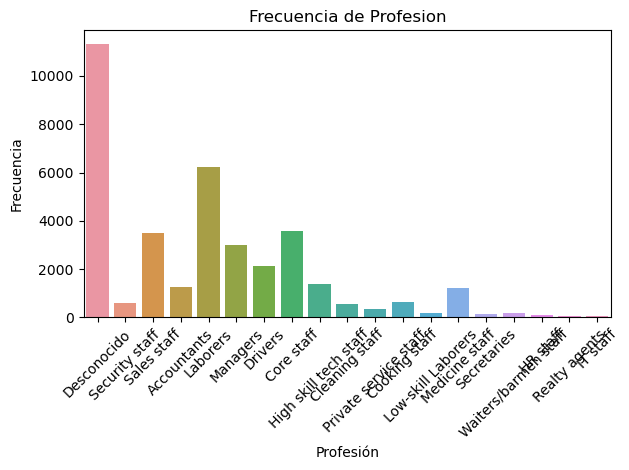

In [68]:
# Gráfico de barras para la columna 'Profesion'
sns.countplot(x='PROFESION', data=clientes_df)
plt.title('Frecuencia de Profesion')
plt.xlabel('Profesión')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

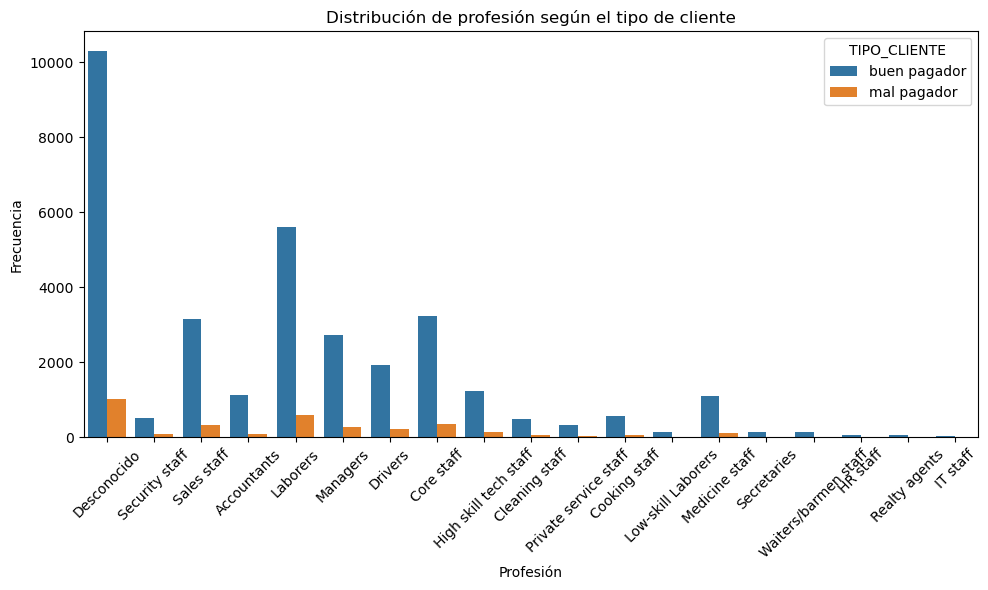

In [69]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PROFESION', hue='TIPO_CLIENTE', data=clientes_df)
plt.title('Distribución de profesión según el tipo de cliente')
plt.xlabel('Profesión')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

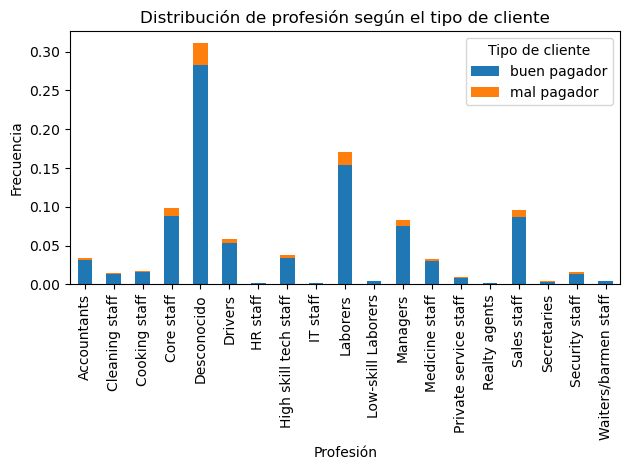

In [70]:
tabla_contingencia.plot(kind='bar', stacked=True)
plt.title('Distribución de profesión según el tipo de cliente')
plt.xlabel('Profesión')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de cliente')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [71]:
clientes_df['PROFESION'].info()

<class 'pandas.core.series.Series'>
Index: 36457 entries, 0 to 434718
Series name: PROFESION
Non-Null Count  Dtype 
--------------  ----- 
36457 non-null  object
dtypes: object(1)
memory usage: 569.6+ KB


In [99]:
tabla_contingencia_pit = pd.crosstab([clientes_df['PROFESION'], clientes_df['NIVEL_INGRESOS']], clientes_df['TIPO_CLIENTE'], normalize=True)
tabla_contingencia_pit

TIPO_CLIENTE                           buen pagador  mal pagador
PROFESION             NIVEL_INGRESOS                            
Accountants           Ingresos bajos       0.030639     0.002743
                      Ingresos medios      0.000631     0.000027
Cleaning staff        Ingresos bajos       0.013550     0.001563
Cooking staff         Ingresos bajos       0.015991     0.001975
Core staff            Ingresos bajos       0.087692     0.010012
                      Ingresos medios      0.000768     0.000027
Desconocido           Ingresos bajos       0.280413     0.027512
                      Ingresos medios      0.002441     0.000219
Drivers               Ingresos bajos       0.052198     0.005815
                      Ingresos medios      0.000631     0.000000
HR staff              Ingresos bajos       0.001893     0.000329
                      Ingresos medios      0.000082     0.000027
High skill tech staff Ingresos bajos       0.033793     0.003868
                      Ingresos medios      0.000247     0.000027
IT staff              Ingresos bajos       0.001317     0.000329
Laborers              Ingresos bajos       0.153606     0.016622
                      Ingresos medios      0.000082     0.000055
Low-skill Laborers    Ingresos bajos       0.004142     0.000658
Managers              Ingresos altos       0.000247     0.000219
                      Ingresos bajos       0.071619     0.006940
                      Ingresos medios      0.003154     0.000439
Medicine staff        Ingresos bajos       0.029926     0.003182
Private service staff Ingresos bajos       0.008723     0.000713
Realty agents         Ingresos bajos       0.001893     0.000274
Sales staff           Ingresos bajos       0.085745     0.009024
                      Ingresos medios      0.000686     0.000137
Secretaries           Ingresos bajos       0.003730     0.000411
Security staff        Ingresos bajos       0.013825     0.002277
                      Ingresos medios      0.000110     0.000027
Waiters/barmen staff  Ingresos bajos       0.004279     0.000494

¿El estado civil y el número de hijos de un cliente son relevantes para definir al cliente?

In [74]:
clientes_df["ESTADO_CIVIL"].describe()

count       36457
unique          5
top       Married
freq        25048
Name: ESTADO_CIVIL, dtype: object

In [75]:
clientes_df["N_NINOS"].describe()

count    36457.000000
mean         0.430315
std          0.742367
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: N_NINOS, dtype: float64

In [76]:
proporcion_estado_civil = clientes_df['ESTADO_CIVIL'].value_counts(normalize=True)
proporcion_estado_civil

ESTADO_CIVIL
Married                 0.687056
Single / not married    0.132457
Civil marriage          0.080780
Separated               0.057684
Widow                   0.042022
Name: proportion, dtype: float64

In [77]:
proporcion_n_ninos = clientes_df['N_NINOS'].value_counts(normalize=True)
proporcion_n_ninos

N_NINOS
0     0.691253
1     0.205502
2     0.089311
3     0.011493
4     0.001728
5     0.000549
14    0.000082
7     0.000055
19    0.000027
Name: proportion, dtype: float64

In [78]:
tabla_contingencia_ec = pd.crosstab(clientes_df['ESTADO_CIVIL'], clientes_df['N_NINOS'])
tabla_contingencia_ec

N_NINOS,0,1,2,3,4,5,7,14,19
ESTADO_CIVIL,,,,,,,,,
Civil marriage,1930,783,211,21,0,0,0,0,0
Married,16274,5460,2866,370,57,19,2,0,0
Separated,1474,524,91,4,6,1,0,3,0
Single / not married,4095,634,81,18,0,0,0,0,1
Widow,1428,91,7,6,0,0,0,0,0


In [79]:
tabla_contingencia_ect = pd.crosstab(clientes_df['ESTADO_CIVIL'], clientes_df['TIPO_CLIENTE'])
tabla_ordenada_filas_ect = tabla_contingencia_ect.sort_values(by='buen pagador', ascending=False)
tabla_ordenada_filas_ect

TIPO_CLIENTE,buen pagador,mal pagador
ESTADO_CIVIL,,
Married,22744,2304
Single / not married,4266,563
Civil marriage,2632,313
Separated,1906,197
Widow,1411,121


In [101]:
tabla_contingencia_c = pd.crosstab([clientes_df['ESTADO_CIVIL'], clientes_df['CAT_HIJOS']], clientes_df['TIPO_CLIENTE'], normalize=True, margins=True)
tabla_ordenada_filas_c = tabla_contingencia_c.sort_values(by='buen pagador', ascending=False)
tabla_ordenada_filas_c

TIPO_CLIENTE                         buen pagador  mal pagador       All
ESTADO_CIVIL         CAT_HIJOS                                          
All                                      0.904051     0.095949  1.000000
Married              Sin hijos           0.406451     0.039937  0.446389
                     De 1 a 2 hijos      0.217407     0.023260  0.240667
Single / not married Sin hijos           0.099377     0.012947  0.112324
Civil marriage       Sin hijos           0.047069     0.005870  0.052939
Separated            Sin hijos           0.036481     0.003950  0.040431
Widow                Sin hijos           0.036015     0.003154  0.039169
Civil marriage       De 1 a 2 hijos      0.025125     0.002716  0.027841
Single / not married De 1 a 2 hijos      0.017637     0.002496  0.020133
Separated            De 1 a 2 hijos      0.015799     0.001454  0.017253
Widow                De 1 a 2 hijos      0.002688     0.000165  0.002853

In [105]:
pd.crosstab(clientes_df['CAT_HIJOS'], clientes_df['TIPO_CLIENTE'], normalize=True, margins=True)

TIPO_CLIENTE,buen pagador,mal pagador,All
CAT_HIJOS,,,
De 1 a 2 hijos,0.278657,0.030090,0.308747
Sin hijos,0.625394,0.065858,0.691253
All,0.904051,0.095949,1.000000


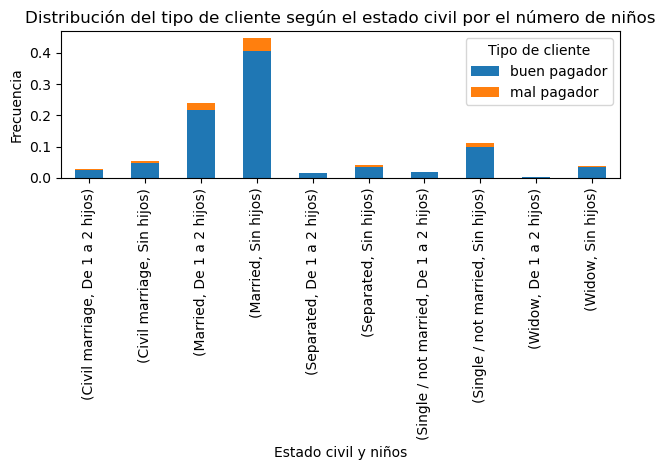

In [81]:
# Gráfico de barras apiladas
tabla_contingencia_c.plot(kind='bar', stacked=True)
plt.title('Distribución del tipo de cliente según el estado civil por el número de niños')
plt.xlabel('Estado civil y niños')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de cliente')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Análisis correlacional 

In [83]:
clientes_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,...,TIENE_EMAIL,PROFESION,N_MIEMBROSFAMILIA,TIPO_CLIENTE,FECHA_NACIMIENTO,ANIO_NACIMIENTO,GENERACION,NIVEL_INGRESOS,NUM_TIPO_CLIENTE,CAT_HIJOS
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,Desconocido,2.0,buen pagador,1991-08-17,1991,Millennials,Ingresos bajos,1,Sin hijos
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,Desconocido,2.0,buen pagador,1991-08-17,1991,Millennials,Ingresos bajos,1,Sin hijos
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Security staff,2.0,buen pagador,1965-09-13,1965,Generación X,Ingresos bajos,1,Sin hijos
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,Sales staff,1.0,buen pagador,1972-03-04,1972,Generación X,Ingresos bajos,1,Sin hijos
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,Sales staff,1.0,buen pagador,1972-03-04,1972,Generación X,Ingresos bajos,1,Sin hijos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434714,5149828,M,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Managers,2.0,mal pagador,1976-12-30,1976,Generación X,Ingresos bajos,0,Sin hijos
434715,5149834,F,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,1,Medicine staff,2.0,mal pagador,1990-07-31,1990,Millennials,Ingresos bajos,0,Sin hijos
434716,5149838,F,0,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,Medicine staff,2.0,mal pagador,1990-07-31,1990,Millennials,Ingresos bajos,0,Sin hijos
434717,5150049,F,0,1,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Sales staff,2.0,mal pagador,1975-04-30,1975,Generación X,Ingresos bajos,0,Sin hijos


In [84]:
####Future transformation
#Variables indicadores : Estabilidad laboral, al menos 2 años de antiguedad.

In [85]:
clientes_df.describe()

,ID_CLIENTE,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,DIAS_DESDE_NACIMIENTO,DIAS_TRABAJANDO,TIENE_CELULAR,TIENE_NUMEROTELEF_LABORAL,TIENE_NUMEROTELEF_PERSONAL,TIENE_EMAIL,N_MIEMBROSFAMILIA,ANIO_NACIMIENTO,NUM_TIPO_CLIENTE
count,3.645700e+04,36457.000000,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.379708,0.672189,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,1980.247908,0.904051
std,4.187524e+04,0.485321,0.469422,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,11.511638,0.294525
min,5.008804e+06,0.000000,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,1955.000000,0.000000
25%,5.042028e+06,0.000000,0.000000,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,1971.000000,1.000000
50%,5.074614e+06,0.000000,1.000000,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,1981.000000,1.000000
75%,5.115396e+06,1.000000,1.000000,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,1990.000000,1.000000
max,5.150487e+06,1.000000,1.000000,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,2003.000000,1.000000


In [86]:
clientes_df['DIAS_TRABAJANDO']

0        -4542
1        -4542
2        -1134
3        -3051
4        -3051
          ... 
434714   -2420
434715   -1325
434716   -1325
434717    -655
434718   -1193
Name: DIAS_TRABAJANDO, Length: 36457, dtype: int64

In [87]:
clientes_df['ANIOS_TRABAJANDO'] = clientes_df['DIAS_TRABAJANDO'].abs() // 365

In [88]:
clientes_df['CATEGORIA_INGRESO'].value_counts()

CATEGORIA_INGRESO
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: count, dtype: int64

In [89]:
# se fija como categorias permitidas las siguientes
categorias_estables = ['Working', 'Commercial associate', 'State servant']
# se crea la variable ESTABILIDAD_TRABAJO , si su categoria es una de las estables y tiene 2 o mas años trabajando
clientes_df['ESTABILIDAD_TRABAJO'] = clientes_df['CATEGORIA_INGRESO'].isin(categorias_estables) & (clientes_df['ANIOS_TRABAJANDO'] >= 2).astype(int)

<Axes: xlabel='TIPO_CLIENTE', ylabel='count'>

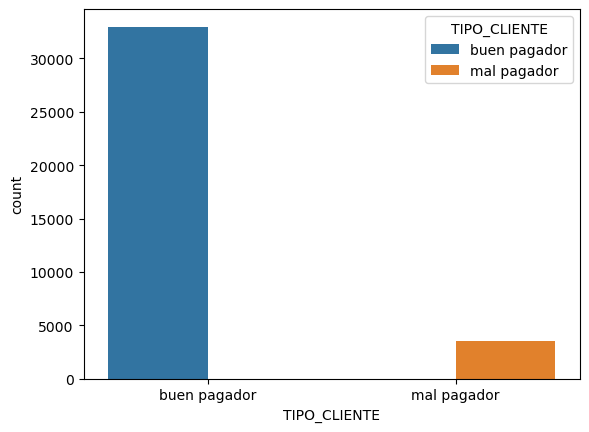

In [90]:
sns.countplot(x='TIPO_CLIENTE', hue='TIPO_CLIENTE', data=clientes_df)

In [91]:
estabilidad_df = clientes_df[clientes_df['CATEGORIA_INGRESO'].isin(categorias_estables)]
estabilidad_df

,ID_CLIENTE,GENERO,TIENE_CARRO,TIENE_PROPIEDADES,N_NINOS,INGRESO_ANUAL,CATEGORIA_INGRESO,NIVEL_EDUCACION,ESTADO_CIVIL,TIPO_CASA,...,N_MIEMBROSFAMILIA,TIPO_CLIENTE,FECHA_NACIMIENTO,ANIO_NACIMIENTO,GENERACION,NIVEL_INGRESOS,NUM_TIPO_CLIENTE,CAT_HIJOS,ANIOS_TRABAJANDO,ESTABILIDAD_TRABAJO
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,2.0,buen pagador,1991-08-17,1991,Millennials,Ingresos bajos,1,Sin hijos,12,True
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,2.0,buen pagador,1991-08-17,1991,Millennials,Ingresos bajos,1,Sin hijos,12,True
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,2.0,buen pagador,1965-09-13,1965,Generación X,Ingresos bajos,1,Sin hijos,3,True
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1.0,buen pagador,1972-03-04,1972,Generación X,Ingresos bajos,1,Sin hijos,8,True
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1.0,buen pagador,1972-03-04,1972,Generación X,Ingresos bajos,1,Sin hijos,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434713,5149775,F,1,1,0,130500.0,Working,Secondary / secondary special,Married,House / apartment,...,2.0,mal pagador,1980-04-24,1980,Generación X,Ingresos bajos,0,Sin hijos,25,True
434714,5149828,M,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,2.0,mal pagador,1976-12-30,1976,Generación X,Ingresos bajos,0,Sin hijos,6,True
434715,5149834,F,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,2.0,mal pagador,1990-07-31,1990,Millennials,Ingresos bajos,0,Sin hijos,3,True
434717,5150049,F,0,1,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,2.0,mal pagador,1975-04-30,1975,Generación X,Ingresos bajos,0,Sin hijos,1,False


In [92]:
estabilidad_df['ESTABILIDAD_TRABAJO'].value_counts(normalize=True)

ESTABILIDAD_TRABAJO
True     0.809632
False    0.190368
Name: proportion, dtype: float64

<Axes: xlabel='CATEGORIA_INGRESO', ylabel='ANIOS_TRABAJANDO'>

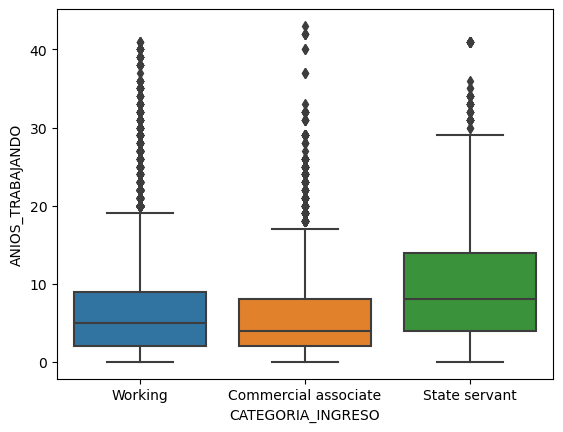

In [93]:
sns.boxplot(x='CATEGORIA_INGRESO', y='ANIOS_TRABAJANDO', data=estabilidad_df)

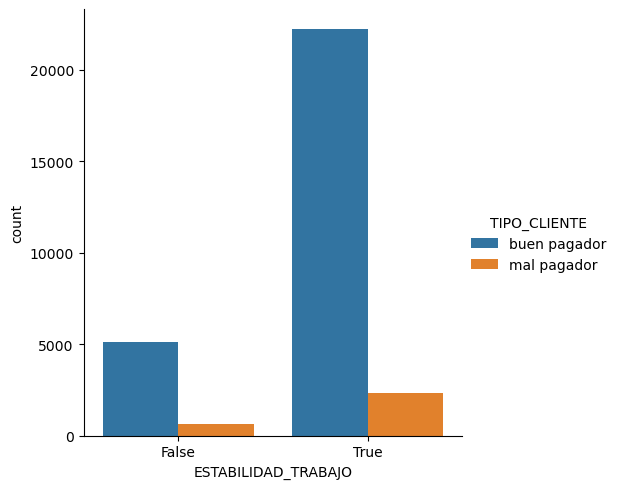

In [94]:
sns.catplot(x='ESTABILIDAD_TRABAJO', hue='TIPO_CLIENTE', kind='count', data=estabilidad_df)

In [95]:
pd.crosstab(estabilidad_df['ESTABILIDAD_TRABAJO'], estabilidad_df['TIPO_CLIENTE'])

TIPO_CLIENTE,buen pagador,mal pagador
ESTABILIDAD_TRABAJO,,
False,5142,625
True,22211,2316


In [96]:
## no aparece la columna TIPO_CLIENTE porque no es un valor numérico 
correlation_matrix=clientes_df.corr()
correlation_matrix

ValueError: could not convert string to float: 'M'

In [ ]:
## con figsize ajustamos el tamano de los cuadros de la matriz
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
clientes_df["INGRESO_ANUAL"].describe().astype(int)

In [ ]:
clientes_df["NIVEL_EDUCACION"].value_counts()

In [ ]:
## correlacion nivel de educacion vs tipo cliente
educacion_df = pd.crosstab(clientes_df['NIVEL_EDUCACION'], clientes_df["TIPO_CLIENTE"], normalize="index")
educacion_df

In [ ]:
educacion_df.reindex(["Academic degree", "Higher education", "Secondary / secondary special", "Lower secondary", "Incomplete higher"])


In [ ]:
educacion_df.plot(kind='bar', stacked=True)
plt.xlabel('Niveles de Educación')
plt.ylabel('Proporción de Tipos de Cliente')
plt.title('Distribución de Tipos de Cliente por Niveles de Educación')
plt.show()

In [ ]:
clientes_df["INGRESO_ANUAL"].max()

In [ ]:
clientes_df["INGRESO_ANUAL"].min()

In [ ]:
#se tendran tres rangos de ingresos 
resta_ingresos_df = (clientes_df["INGRESO_ANUAL"].max())-(clientes_df["INGRESO_ANUAL"].min())
resta_ingresos_df/3

In [ ]:
clientes_df["NIVEL_INGRESOS"].value_counts()

In [ ]:
ingresos_df = pd.crosstab(clientes_df["NIVEL_INGRESOS"], clientes_df["TIPO_CLIENTE"], normalize="index")
ingresos_df

In [ ]:
ingresos_df.reindex(["Ingresos bajos", "Ingresos medios", "Ingresos altos"])

In [ ]:
ingresos_df.plot(kind='bar', stacked=True)
plt.xlabel('Niveles de Ingresos')
plt.ylabel('Proporción de Tipos de Cliente')
plt.title('Distribución de Tipos de Cliente por Niveles de Ingresos')
plt.show()


In [ ]:
union_df = pd.crosstab([clientes_df["NIVEL_INGRESOS"], clientes_df["NIVEL_EDUCACION"]] , clientes_df["TIPO_CLIENTE"], normalize="index")
union_df



In [ ]:
union_df.plot(kind='bar', stacked=True)
plt.xlabel('Niveles de Ingresos')
plt.ylabel('Proporción de Tipos de Cliente')
plt.title('Distribución de Tipos de Cliente por Niveles de Ingresos')
plt.show()